# MA4829 Group Assignment


In [1]:
### IMPORT PACKAGES ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb
from sklearn.decomposition import PCA
from apyori import apriori
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random

### INCLUDE GRAPHS IN NOTEBOOK AUTOMATICALLY ###
%matplotlib inline 
from IPython.display import display, Latex

## Import Data

1. Convert the Excel file to a supported file type (Product_Survey_Results.csv) 
2. Read the file using `pandas` package and convert it into a dataframe
3. The data has 13 columns and 100 rows

In [2]:
#load csv file
raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Current Sem/MA4829 Machine Intelligence/CA/Product Development Analysis Project/Product_Survey_Results.csv');
#create dataframe
df = pd.DataFrame(raw_data);

print('Shape of dataframe: ', df.shape)
#display(Latex(df.head(n=2).to_latex()))
df.head(n=2)

Shape of dataframe:  (100, 13)


,Timestamp,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)"
0,2021/09/26 4:11:56 PM GMT+8,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch"
1,2021/10/08 1:03:51 PM GMT+8,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Aesthetics;Technological features;Functi...,Very likely,Headlights;Side mirrors;Bumpers,Centre compartment;Door handles;Dashboard,500-1000,Only with professional help,over 1000,"No, I would need a designer to model my sketch"


## Data Preprocessing

Since machine learning models only work with numerical or categorical features, some preprocessing of text is required. 

1. Remove timestamp column
2. Fill all NA values with string 'missing' (there is 1 in marriage, 1 in car_factors, 2 in car_exterior)
3. Rename columns for readability: `age_group`, `gender`, `category`, `marriage`, `car_factors`, `car_buy_interest`, `car_exterior`, `car_interior`, `car_customize_cost`, `car_design_interest`, `car_design_cost`, `car_design_exp`


### One Hot Encoding

Within the survey, there are questions with binary and multiple response.

1. Binary response, such as gender and yes/no can be encoded as 0 and 1
2. Multiple response, such as car factors or car customization parts can be converted into binary via one-hot encoding. For instance, the car factor `[Price, Aesthetics]` will be split into two columns `Price` and `Aesthetics`. For each row, the value is 1 if the factor is given in the response otherwise it is 0.
3. Convert remaining responses into categorical data type.

Note: `new_df` is all category, `num_df` is all numeric

In [3]:
#remove time column
new_df = df.drop(['Timestamp'], axis = 1)

#missing response
new_df = new_df.fillna(value = 'missing')

#rename column
col_name = list(new_df.columns)
col_list       = ['age_group',
                 'gender',
                 'category',
                 'marriage',
                 'car_factors',
                 'car_buy_interest',
                 'car_exterior',
                 'car_interior',
                 'car_customize_cost',
                 'car_design_interest',
                 'car_design_cost'
                 ,'car_design_exp']
col_to_rename = {}
for index, name in enumerate(col_name):
    col_to_rename[name] = col_list[index]
new_df = new_df.rename(col_to_rename, axis = 1)

#categorical response
category_cols = ['age_group',
                 'gender',
                 'category',
                 'marriage',
                 'car_buy_interest',
                 'car_customize_cost',
                 'car_design_interest',
                 'car_design_cost'
                 ,'car_design_exp']
new_df[category_cols] = new_df[category_cols].astype('category')

#multiple response
string_cols = ['car_factors',
               'car_exterior',
               'car_interior']
new_df[string_cols] = new_df[string_cols].astype('string')

def get_unique_item(nestedlist):
    unique_items = []
    for lists in nestedlist:
        for x in lists:
            if x not in unique_items: unique_items.append(x)
    return unique_items

#create dataframe to collate
multi_df = pd.DataFrame()
for column in string_cols:
    #create temporary dataframe
    temp_df = pd.DataFrame()
    #convert strings into list ['price', 'functionality'...]
    value_list = new_df[column].str.split(';').tolist()
    new_df[column] = value_list
    #get unique items from list
    unique_list = get_unique_item(value_list)
    #one-hot encode 
    for item in unique_list:
        temp_df[item] = new_df[column].transform(lambda x: int(item in x))
    #combine dataframe
    temp_df.columns = pd.MultiIndex.from_product([[column], temp_df])
    multi_df = pd.concat([multi_df, temp_df], axis = 1)
    

#combine FULL dataframe
new_df.columns = pd.MultiIndex.from_product([['basic'], new_df])
new_df = pd.concat([new_df, multi_df], axis = 1)
#display(Latex(new_df.head(n=2).to_latex()))
new_df.head(n=2)

basic                                                            \
  age_group gender                                           category   
0     20-30   Male  Do not own a car, but planning to purchase in ...   
1     20-30   Male  Do not own a car, but planning to purchase in ...   

                                                               \
  marriage                                        car_factors   
0   Single  [Price, Functionality, Size, Customisable opti...   
1   Single  [Price, Aesthetics, Technological features, Fu...   

                                                         \
  car_buy_interest                         car_exterior   
0      Very likely                            [Grilles]   
1      Very likely  [Headlights, Side mirrors, Bumpers]   

                                                                     \
                                    car_interior car_customize_cost   
0                           [Centre compartment]            100-500   
1  [Centre compartment, Door handles, Dashboard]           500-1000   

                                ...  \
           car_design_interest  ...   
0  Only with professional help  ...   
1  Only with professional help  ...   

                                             car_exterior       car_interior  \
  add body kit and change the exhaust and tune the engine Centre compartment   
0                                                  0                       1   
1                                                  0                       1   

                                                                          \
  Door handles Dashboard Steering wheel Sun blocker for front passengers   
0            0         0              0                                0   
1            1         1              0                                0   

                                                    \
  Arm rest, position of gear shifter if applicable   
0                                                0   
1                                                0   

                                                  
  Music Player and sound systems air vent Design  
0                              0        0      0  
1                              0        0      0  

[2 rows x 39 columns]

In [4]:
mapped_dict = {}
#convert category into all numeric
numeric_df = pd.DataFrame()
for col in category_cols:
    #map category by column
    numeric_df[col] = pd.Categorical(new_df['basic'][col], categories = new_df['basic'][col].unique().sort_values(ascending=True)).codes
    #save mapping in dictionary
    mapped_dict[col] = [x for x in enumerate(list(new_df['basic'][col].unique().sort_values(ascending=True)))]


numeric_df.columns 
print(mapped_dict)

#combine FULL dataframe
numeric_df.columns = pd.MultiIndex.from_product([['basic'], numeric_df])
numeric_df = pd.concat([numeric_df, multi_df], axis = 1)
#display(Latex(numeric_df.head(n=3).to_latex()))
numeric_df.head(n=2)

{'age_group': [(0, '20-30'), (1, '51-60'), (2, '31-40'), (3, '41-50')], 'gender': [(0, 'Male'), (1, 'Female'), (2, 'Prefer not to say')], 'category': [(0, 'Do not own a car, but planning to purchase in future'), (1, 'Own more than one car'), (2, 'Own a car')], 'marriage': [(0, 'Single'), (1, 'missing'), (2, 'Married with children'), (3, 'Married with no children')], 'car_buy_interest': [(0, 'Very likely'), (1, 'Likely'), (2, 'Not likely')], 'car_customize_cost': [(0, '100-500'), (1, '500-1000'), (2, 'under 500'), (3, 'over 1000'), (4, '0')], 'car_design_interest': [(0, 'Only with professional help'), (1, 'Yes'), (2, 'No')], 'car_design_cost': [(0, '500-1000'), (1, 'over 1000'), (2, 'under 500'), (3, '0')], 'car_design_exp': [(0, 'No, I would need a designer to model my sketch'), (1, 'Yes, I can design on my own')]}


basic                                                               \
  age_group gender category marriage car_buy_interest car_customize_cost   
0         0      0        0        0                0                  0   
1         0      0        0        0                0                  1   

                                                     car_factors  ...  \
  car_design_interest car_design_cost car_design_exp       Price  ...   
0                   0               0              0           1  ...   
1                   0               1              0           1  ...   

                                             car_exterior       car_interior  \
  add body kit and change the exhaust and tune the engine Centre compartment   
0                                                  0                       1   
1                                                  0                       1   

                                                                          \
  Door handles Dashboard Steering wheel Sun blocker for front passengers   
0            0         0              0                                0   
1            1         1              0                                0   

                                                    \
  Arm rest, position of gear shifter if applicable   
0                                                0   
1                                                0   

                                                  
  Music Player and sound systems air vent Design  
0                              0        0      0  
1                              0        0      0  

[2 rows x 36 columns]

### Data Visualization

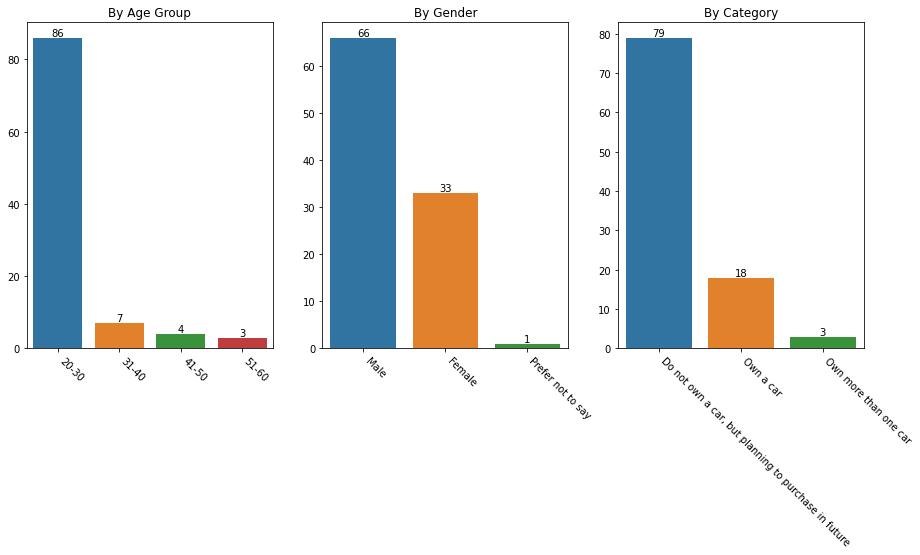

In [5]:
titles = [
    'By Age Group',
    'By Gender',
    'By Category',
]

fig, axes = plt.subplots(1,3,figsize=(15,6))

for i, ax in enumerate(axes.flat):
    plot_data = pd.DataFrame(new_df['basic'][category_cols[i]].value_counts()).T
    sb.barplot(data = plot_data, ax = ax)
    ax.set_title(titles[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-45, ha='left')
    ax.bar_label(ax.containers[0]);

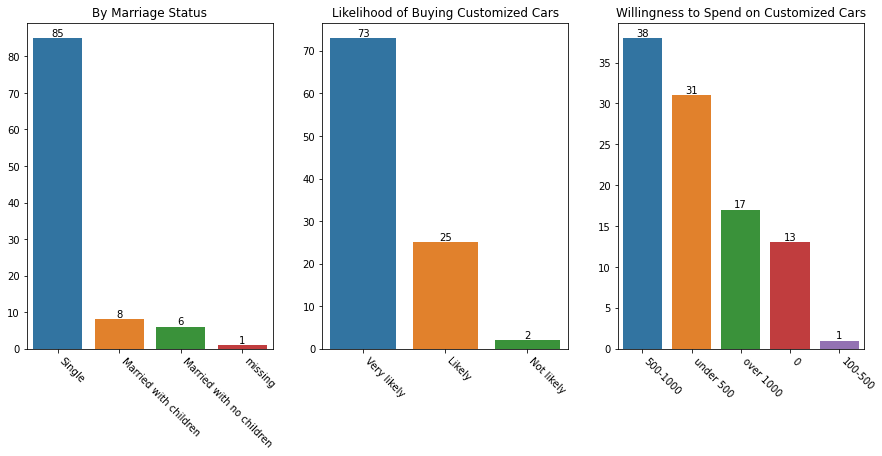

In [6]:
titles = [
    'By Marriage Status',
    'Likelihood of Buying Customized Cars',
    'Willingness to Spend on Customized Cars'
]

fig, axes = plt.subplots(1,3,figsize=(15,6))

for i, ax in enumerate(axes.flat):
    plot_data = pd.DataFrame(new_df['basic'][category_cols[i+3]].value_counts()).T
    sb.barplot(data = plot_data, ax = ax)
    ax.set_title(titles[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-45, ha='left')
    ax.bar_label(ax.containers[0]);

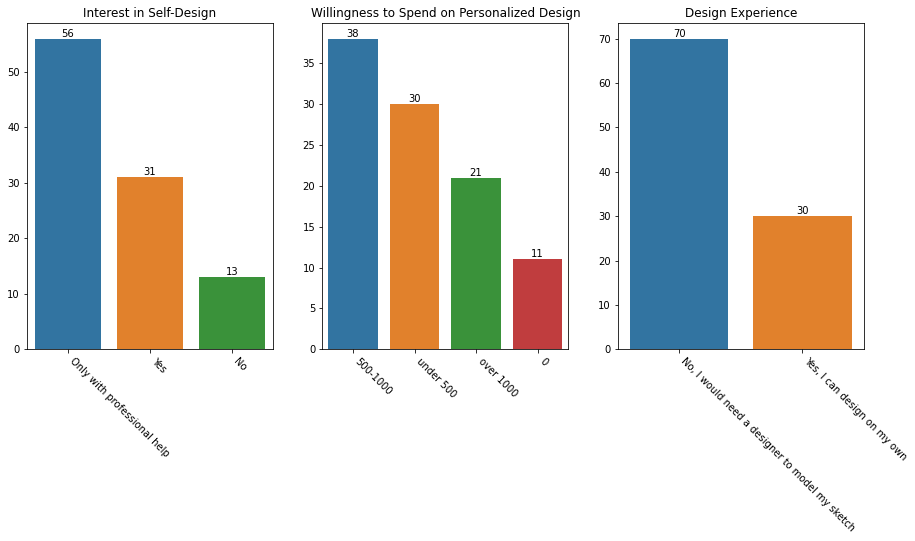

In [7]:
titles = [
    'Interest in Self-Design',
    'Willingness to Spend on Personalized Design',
    'Design Experience'
]

fig, axes = plt.subplots(1,3,figsize=(15,6))

for i, ax in enumerate(axes.flat):
    plot_data = pd.DataFrame(new_df['basic'][category_cols[i+6]].value_counts()).T
    sb.barplot(data = plot_data, ax = ax)
    ax.set_title(titles[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-45, ha='left')
    ax.bar_label(ax.containers[0]);

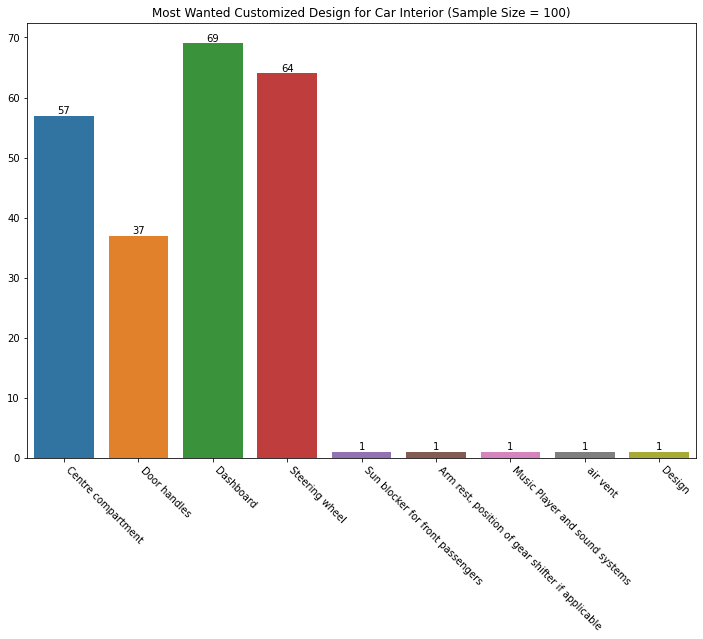

In [8]:
plot_data = pd.DataFrame(new_df['car_interior'].sum()).T
fig, ax = plt.subplots(figsize=(12,8))
sb.barplot(data=plot_data)
ax.set_title('Most Wanted Customized Design for Car Interior (Sample Size = 100)')
plt.xticks(rotation=-45, ha='left');
ax.bar_label(ax.containers[0]);

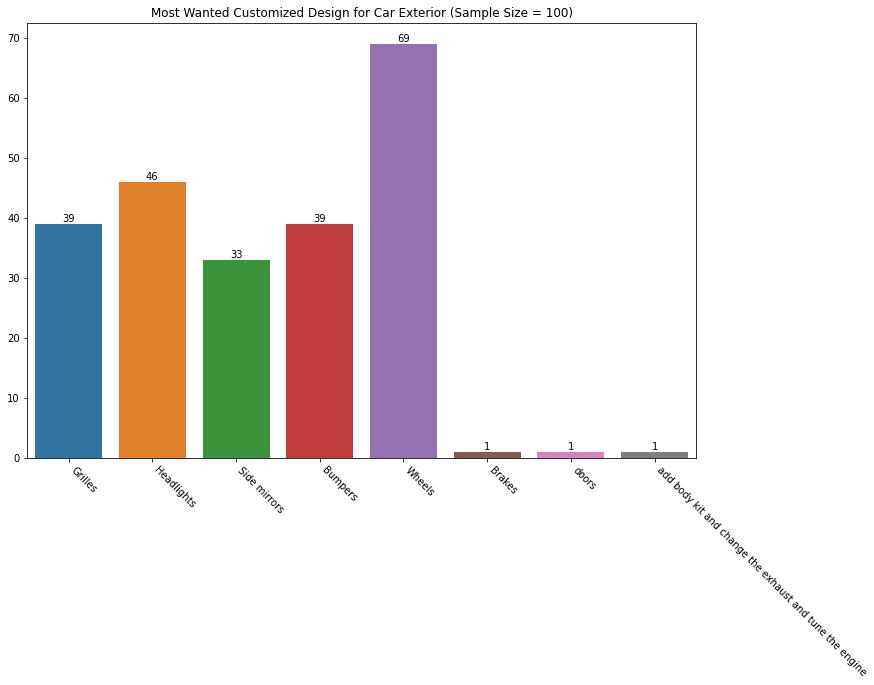

In [9]:
plot_data = pd.DataFrame(new_df['car_exterior'].sum()).T
plot_data = plot_data.drop(['missing'], axis =1 )
fig, ax = plt.subplots(figsize=(12,8))
sb.barplot(data=plot_data)
ax.set_title('Most Wanted Customized Design for Car Exterior (Sample Size = 100)')
plt.xticks(rotation=-45, ha='left');
ax.bar_label(ax.containers[0]);

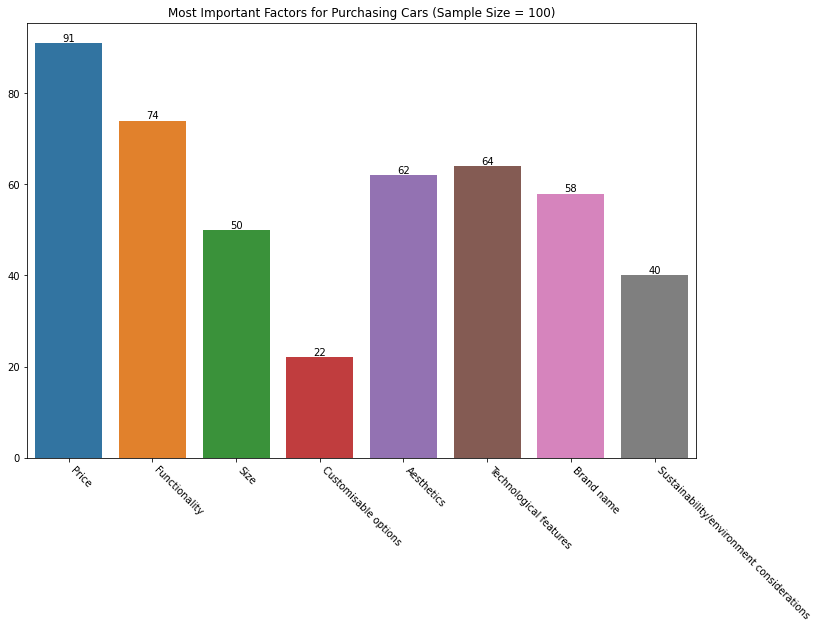

In [10]:
plot_data = pd.DataFrame(new_df['car_factors'].sum()).T
plot_data = plot_data.drop(['missing'], axis =1 )
fig, ax = plt.subplots(figsize=(12,8))
sb.barplot(data=plot_data)
ax.set_title('Most Important Factors for Purchasing Cars (Sample Size = 100)')
plt.xticks(rotation=-45, ha='left');
ax.bar_label(ax.containers[0]);

## General Knowledge Inference 

The most important factors when purchasing cars and the most wanted car components was determined by counting the frequency of each factor. Car designers can use these factors to base their economic decision making or optimization of car design. Some application of this knowledge are

**A. Predict the customer rating of a new car model**

- All the features of the car are ranked from 0 to 10 according to the preference of the customer. Each of the factors can be weighted to find the overall car rating using a fuzzy membership function. 
- Assumes that price and functionality can be given a numeric scale (pressumably by a car expert).
- Limitation: Requires carrying out survey which may be costly and the customer preference may change over time


**B. Forecast the market demand of a new car model**

- To find the likelihood of customer purchasing a car, logistic regression can be applied. The input to the model are the customer rating of the car features. The sigmoid function will then map the input to either 0 (not buying) and 1 (buying). 
- Limitations: Requires labelled data (where outcome of the customer buying/not buying is already known) because it is a supervised learning model

**C. Determine the profit of a new car model**

- Since Profit = Revenue - Cost and Revenue = Demand * Price
- Perform linear regression of the car features to predict the market selling price. 
- Limitations: Requires labelled data. Information about car prices may be difficult to obtain and historical car prices may not be applicable to new car models.

**D. Recommend customer for car customized parts**

- Create a recommendation system based on knowledge inferred from the car customisation survey dataset
- Make use of apriori algorithm and fuzzy dataset (see below)
- Limitations: Customer preference may change over time and application of fuzzy logic may be incorrect if the implemented rules are not rational

## Principle Component Analysis

The `sklearn` package was used.


Principle component analysis is often used to reduce the dimensions of continuous variable. PCA uses the covariance relationship between dependent variable X to find a set of eigenvectors. These eigenvectors can be plotted in a biplot. Eigenvectors that are orthogonal are desired as it represent that the projected data is able to capture the most variance of the entire dataset.

For the survey, X is the categorical variable that takes value of 0 to 3. Each columns are normalized using min-max for PCA so that the distance between 2 different categories is equal. For categorical variable, the linear discriminant analysis (LDA) is usually used rather than PCA. Nevertheless, the data was fitted with PCA for quick visualization.

Eigenvectors are  [[-0.07217638 -0.15205436 -0.36739018 -0.04793935  0.06617413 -0.1487717
   0.05721318 -0.39380632  0.8059327 ]
 [ 0.34952128 -0.05680496  0.66707583  0.42843941  0.12253829  0.11988964
   0.27660137  0.05632756  0.37011798]
 [-0.24238909  0.21979359 -0.04316549 -0.28945212 -0.05965283  0.42268172
   0.08286339  0.68114881  0.39273932]
 [-0.08155958  0.0025632  -0.17274063 -0.12397396  0.17520455 -0.02674626
   0.93333043 -0.0562896  -0.20602523]
 [ 0.16712917  0.40208586 -0.39733561  0.405655    0.58646313  0.35194695
  -0.12194177 -0.04041867 -0.0604493 ]
 [-0.18733188 -0.5288392   0.16444389 -0.24572598  0.73023644 -0.09502481
  -0.15482097  0.1735866  -0.0378947 ]
 [ 0.28225508 -0.68677939 -0.36824045  0.23487751 -0.24829512  0.39732803
   0.03977233  0.17307412 -0.08271117]
 [-0.38781943 -0.06338514  0.25926718 -0.12914881 -0.03903114  0.68111695
  -0.02382119 -0.53934555 -0.06909945]
 [ 0.71702425  0.0911555   0.02436871 -0.64668797  0.07740865  0.17155764
  -0.

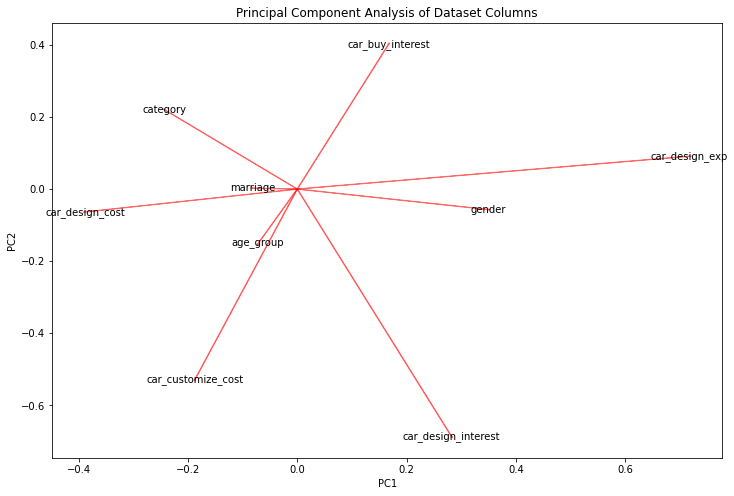

In [11]:
#normalize columns using min-max
norm_df = pd.DataFrame()
norm_df = (numeric_df['basic']-numeric_df['basic'].min())/(numeric_df['basic'].max()-numeric_df['basic'].min())
X = norm_df 
#apply pca
pca = PCA().fit(X)
print('Eigenvectors are ', pca.components_)
print('Eigenvalues are ', pca.explained_variance_)
plt.figure(figsize=(12,8))
#get eigenvectors
vec = pca.components_
n =vec.shape[0]
labels = [x for x in X.columns]
#plot vectors
for i in range(n):
    plt.arrow(0, 0, vec[i,0], vec[i,1],color = 'r',alpha = 0.5)
    plt.text(vec[i,0], vec[i,1], labels[i], color = 'k', ha = 'center', va = 'center')
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('Principal Component Analysis of Dataset Columns');

The PCA plot suggests that the most important vectors that can capture the variance of the dataset are car customize cost and car design experience as given by the length of the vectors. In addition, the columns of marriage, age group and gender capture the least variance of the dataset.

Eigenvectors are  [[-0.06684214 -0.2738293  -0.44111909 -0.22418699 -0.41740394 -0.4443853
  -0.52067165 -0.17769946  0.03637813]
 [-0.03053356  0.3174316   0.13207336  0.22107309 -0.37016374  0.09261278
  -0.4004127   0.72526622 -0.00696117]
 [ 0.09901157 -0.14092718  0.77255593 -0.11848401 -0.13230552 -0.58164977
   0.06018259  0.00128395  0.00321139]
 [-0.0294134  -0.3791766  -0.04834943  0.33342558  0.70091514 -0.24007228
  -0.34771422  0.26834951  0.00403749]
 [-0.10116537  0.68948814 -0.11925762  0.42519798  0.10974377 -0.45736957
  -0.0231251  -0.31233319 -0.00620878]
 [ 0.00461638 -0.41841335 -0.10672347  0.71210468 -0.402598   -0.0541212
   0.37545999 -0.00538811  0.02030984]
 [-0.15412699  0.05935512 -0.36345055 -0.29615488  0.07157902 -0.42127342
   0.54969128  0.51783197  0.00353841]
 [-0.96693281 -0.07302659  0.1762447  -0.00777709 -0.01647999  0.09131828
  -0.01678997 -0.06662598  0.1235064 ]
 [ 0.12231701  0.03605247 -0.00441143 -0.00109502  0.02102343  0.00818992
   0.0

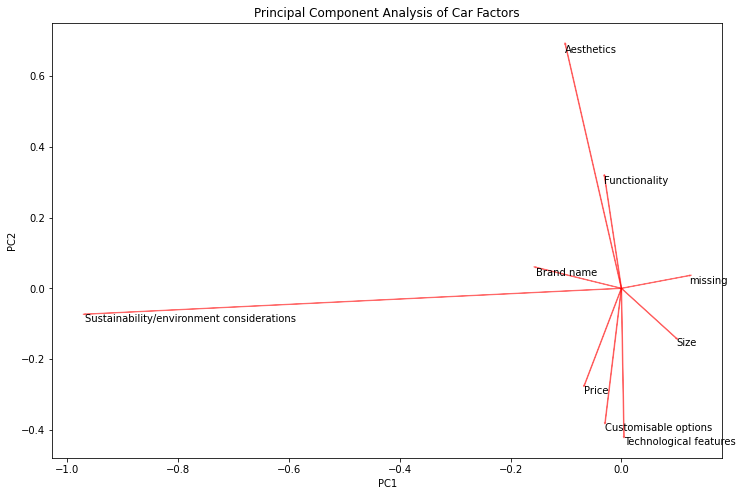

In [12]:
#normalize columns using min-max
norm_df = pd.DataFrame()
norm_df = (numeric_df['car_factors']-numeric_df['car_factors'].min())/(numeric_df['car_factors'].max()-numeric_df['car_factors'].min())
X = norm_df
#apply pca
pca = PCA().fit(X)
print('Eigenvectors are ', pca.components_)
print('Eigenvalues are ', pca.explained_variance_)
plt.figure(figsize=(12,8))
#get eigenvectors
vec = pca.components_
n =vec.shape[0]
labels = [x for x in X.columns]
#plot vectors
for i in range(n):
    plt.arrow(0, 0, vec[i,0], vec[i,1],color = 'r',alpha = 0.5)
    plt.text(vec[i,0], vec[i,1], labels[i], color = 'k', ha = 'left', va = 'top')
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('Principal Component Analysis of Car Factors');

The PCA plot suggests that sustainability and aesthetics are the most important vectors. However, from data visualisation it is known that price and functionality are the top two most important factors by frequency. This shows that the PCA is not valid for dimension reduction for car factors.

## Probability 

The conditional probability is given by $P(A|B) = \frac{P(A \cap B)}{P(B)}$. The joint probability is given by $P(A \cap B)$. Some questions on probability that can be inferred are:

1. What is the probability of someone paying over X amounts for car customisation GIVEN a specific exterior components to customize?
2. What is the probability of someone paying over X amounts for car customisation GIVEN a specific interior components to customize? 
3. What is the probability of someone paying over X amounts for car customisation GIVEN the preference of car factors? 
4. What is the probability of someone paying over X amounts for personalized car design GIVEN their experience in 3D CAD.


Note: this probability may only be applicable for the sample size and not representative of the entire population.

The mapped dictionary is given as `{'age_group': [(0, '20-30'), (1, '51-60'), (2, '31-40'), (3, '41-50')], 'gender': [(0, 'Male'), (1, 'Female'), (2, 'Prefer not to say')], 'category': [(0, 'Do not own a car, but planning to purchase in future'), (1, 'Own more than one car'), (2, 'Own a car')], 'marriage': [(0, 'Single'), (1, 'missing'), (2, 'Married with children'), (3, 'Married with no children')], 'car_buy_interest': [(0, 'Very likely'), (1, 'Likely'), (2, 'Not likely')], 'car_customize_cost': [(0, '100-500'), (1, '500-1000'), (2, 'under 500'), (3, 'over 1000'), (4, '0')], 'car_design_interest': [(0, 'Only with professional help'), (1, 'Yes'), (2, 'No')], 'car_design_cost': [(0, '500-1000'), (1, 'over 1000'), (2, 'under 500'), (3, '0')], 'car_design_exp': [(0, 'No, I would need a designer to model my sketch'), (1, 'Yes, I can design on my own')]}` 

Note: The mapped dict may change based on different operating system. Use the mapped dictionary in the code rather than the copy paste. 

In [13]:
def get_key(A, istr):
    for ea in mapped_dict[A]:
        i = ea[0]
        st = ea[1]
        if st == istr: return str(i)

In [14]:
#prob 3
print('QUESTION 3')
A = 'car_customize_cost'
result = pd.DataFrame()

for part in numeric_df['car_exterior'].columns:
    n_B = numeric_df['car_exterior'].sum()[part]
    for cost in mapped_dict[A]:
        id_A = list(numeric_df['basic'].query(A+'=='+str(cost[0])).index)
        n_A = len(id_A)
        try:
            n_AB = numeric_df['car_exterior'].loc[id_A, part].value_counts()[1] #take 1, not 0
        except:
            n_AB = 0
        P = n_AB / n_B
        result.loc[cost[1], part] = P

print('The probability of paying X amount GIVEN that the person wishes to customize an exterior part')
#display(Latex(result.iloc[:,:6].to_latex()))
result

QUESTION 3
The probability of paying X amount GIVEN that the person wishes to customize an exterior part


,Grilles,Headlights,Side mirrors,Bumpers,Wheels,missing,Brakes,doors,add body kit and change the exhaust and tune the engine
100-500,0.025641,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
500-1000,0.384615,0.391304,0.333333,0.358974,0.434783,0.0,0.0,0.0,0.0
under 500,0.333333,0.304348,0.424242,0.384615,0.304348,0.5,0.0,1.0,1.0
over 1000,0.153846,0.217391,0.121212,0.128205,0.188406,0.0,0.0,0.0,0.0
0,0.102564,0.086957,0.121212,0.128205,0.072464,0.5,1.0,0.0,0.0


In [15]:
#prob 4
print('QUESTION 4')
A = 'car_customize_cost'
result = pd.DataFrame()

for part in numeric_df['car_interior'].columns:
    n_B = numeric_df['car_interior'].sum()[part]
    for cost in mapped_dict[A]:
        id_A = list(numeric_df['basic'].query(A+'=='+str(cost[0])).index)
        n_A = len(id_A)
        try:
            n_AB = numeric_df['car_interior'].loc[id_A, part].value_counts()[1]
        except:
            n_AB = 0
        P = n_AB / n_B
        result.loc[cost[1], part] = P
print('The probability of paying X amount GIVEN that the person wishes to customize an interior part')
#display(Latex(result.iloc[:,:5].to_latex()))
result

QUESTION 4
The probability of paying X amount GIVEN that the person wishes to customize an interior part


,Centre compartment,Door handles,Dashboard,Steering wheel,Sun blocker for front passengers,"Arm rest, position of gear shifter if applicable",Music Player and sound systems,air vent,Design
100-500,0.017544,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
500-1000,0.333333,0.324324,0.362319,0.390625,0.0,0.0,1.0,1.0,1.0
under 500,0.333333,0.324324,0.333333,0.328125,1.0,0.0,0.0,0.0,0.0
over 1000,0.175439,0.189189,0.173913,0.187500,0.0,1.0,0.0,0.0,0.0
0,0.140351,0.162162,0.130435,0.093750,0.0,0.0,0.0,0.0,0.0


In [16]:
#prob 5
print('QUESTION 5')
A = 'car_customize_cost'
result = pd.DataFrame()

for part in numeric_df['car_factors'].columns:
    n_B = numeric_df['car_factors'].sum()[part]
    for cost in mapped_dict[A]:
        id_A = list(numeric_df['basic'].query(A+'=='+str(cost[0])).index)
        n_A = len(id_A)
        try:
            n_AB = numeric_df['car_factors'].loc[id_A, part].value_counts()[1]
        except:
            n_AB = 0
        P = n_AB / n_B  
        result.loc[cost[1], part] = P
        
print('The probability of paying X amount GIVEN that the person has preference for a car factor')
#display(Latex(result.iloc[:,5:].to_latex()))
result

QUESTION 5
The probability of paying X amount GIVEN that the person has preference for a car factor


,Price,Functionality,Size,Customisable options,Aesthetics,Technological features,Brand name,Sustainability/environment considerations,missing
100-500,0.010989,0.013514,0.02,0.045455,0.000000,0.00000,0.000000,0.000,0.0
500-1000,0.362637,0.378378,0.34,0.318182,0.451613,0.34375,0.362069,0.275,0.0
under 500,0.340659,0.310811,0.40,0.272727,0.290323,0.31250,0.310345,0.400,0.0
over 1000,0.142857,0.162162,0.12,0.272727,0.145161,0.21875,0.224138,0.175,1.0
0,0.142857,0.135135,0.12,0.090909,0.112903,0.12500,0.103448,0.150,0.0


In [17]:
print('The probability of paying X amount GIVEN that the person has preference for a car factor')
#display(Latex(result.iloc[:,:5].to_latex()))
result.iloc[:,:5]

The probability of paying X amount GIVEN that the person has preference for a car factor


,Price,Functionality,Size,Customisable options,Aesthetics
100-500,0.010989,0.013514,0.02,0.045455,0.000000
500-1000,0.362637,0.378378,0.34,0.318182,0.451613
under 500,0.340659,0.310811,0.40,0.272727,0.290323
over 1000,0.142857,0.162162,0.12,0.272727,0.145161
0,0.142857,0.135135,0.12,0.090909,0.112903


In [18]:
#prob 6
print('QUESTION 6')
A = 'car_design_cost'
B = 'car_design_exp'
result = pd.DataFrame()

for experience in mapped_dict[B]:
    n_B = numeric_df['basic'].query(B+'=='+str(experience[0])).shape[0]
    n_T = numeric_df['basic'].shape[0]
    for cost in mapped_dict[A]:
        n_AB = numeric_df['basic'].query(B+'=='+str(experience[0])+' and '+A+'=='+str(cost[0])).shape[0]
        P = (n_AB / n_T) / (n_B / n_T)  
        result.loc[cost[1], experience[1]] = P
        
print('The probability of paying X amount GIVEN that the person has preference for a car factor')
#display(Latex(result.to_latex()))
result

QUESTION 6
The probability of paying X amount GIVEN that the person has preference for a car factor


,"No, I would need a designer to model my sketch","Yes, I can design on my own"
500-1000,0.342857,0.466667
over 1000,0.185714,0.266667
under 500,0.342857,0.200000
0,0.128571,0.066667


## Association Rule Mining Using Apriori Algorithm

The `Apyori` package from Pypi was used.


### Analysis of Car Factors and Design Components

Counting the frequency and choosing K most important factors is one method to learn about customer preference. However, most factors are not isolated and it may be more meaningful to determine how factors are associated when grouped together. Association learning can be done using the Apriori Algorithm. 

Similar to market basket analysis, the goal is to determine association rule in the form of A --> B, where customer who buy item A will also buy item B. Each rule are evaluated using support (joint probability of A and B) and confidence (conditional probability of A and B given A). 

In [19]:
records = list(new_df['basic'].loc[:,'car_factors'])
#apply apriori
association_rules = apriori(records, min_support=0.3, min_confidence=0.8, min_lift=1, max_length=3)
association_results = list(association_rules)
#print result
result = pd.DataFrame(columns = ['Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift'])
ruleno = 1
for item in association_results:
    pair = item[0] 
    pair_list = [x for x in pair]
    result.at['Rule' + str(ruleno), 'Antecedent'] = pair_list[0:-1]
    result.loc['Rule' + str(ruleno), 'Consequent'] = pair_list[-1]
    result.loc['Rule' + str(ruleno), 'Support'] = item[1]
    result.loc['Rule' + str(ruleno), 'Confidence'] = item[2][0][2]
    result.loc['Rule' + str(ruleno), 'Lift'] = item[2][0][3]
    ruleno += 1
#display(Latex(result.to_latex()))
result

,Antecedent,Consequent,Support,Confidence,Lift
Rule1,[],Price,0.91,0.91,1
Rule2,[Aesthetics],Price,0.57,0.919355,1.01028
Rule3,[Price],Brand name,0.54,0.931034,1.02311
Rule4,[Functionality],Size,0.4,0.8,1.08108
Rule5,[Functionality],Sustainability/environment considerations,0.34,0.85,1.14865
Rule6,[Technological features],Functionality,0.52,0.8125,1.09797
Rule7,[Size],Price,0.48,0.96,1.05495
Rule8,[Technological features],Price,0.59,0.921875,1.01305
Rule9,"[Aesthetics, Price]",Brand name,0.41,0.953488,1.04779
Rule10,"[Technological features, Functionality]",Aesthetics,0.37,0.804348,1.25679


In [20]:
records = list(new_df['basic'].loc[:,'car_interior'])

association_rules = apriori(records, min_support=0.01, min_confidence=0.6, min_lift=1, max_length =4)
association_results = list(association_rules)

result = pd.DataFrame(columns = ['Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift', 'Quantity'])
ruleno = 1
for item in association_results:
    pair = item[0] 
    pair_list = [x for x in pair]
    result.loc['Rule' + str(ruleno), 'Antecedent'] = pair_list[0:-1]
    result.loc['Rule' + str(ruleno), 'Consequent'] = pair_list[-1]
    result.loc['Rule' + str(ruleno), 'Support'] = item[1]
    result.loc['Rule' + str(ruleno), 'Confidence'] = item[2][0][2]
    result.loc['Rule' + str(ruleno), 'Lift'] = item[2][0][3]
    result.loc['Rule' + str(ruleno), 'Quantity'] = len(pair_list)
    ruleno += 1
#display(Latex(result.iloc[:,0:-1].to_latex()))
result

,Antecedent,Consequent,Support,Confidence,Lift,Quantity
Rule1,[],Dashboard,0.69,0.69,1,1
Rule2,[],Steering wheel,0.64,0.64,1,1
Rule3,"[Arm rest, position of gear shifter if applica...",Centre compartment,0.01,1,1.75439,2
Rule4,[Dashboard],"Arm rest, position of gear shifter if applicable",0.01,1,1.44928,2
Rule5,"[Arm rest, position of gear shifter if applica...",Door handles,0.01,1,2.7027,2
Rule6,[Steering wheel],"Arm rest, position of gear shifter if applicable",0.01,1,1.5625,2
Rule7,[Design],Centre compartment,0.01,1,1.75439,2
Rule8,[Door handles],Centre compartment,0.27,0.72973,1.28023,2
Rule9,[Music Player and sound systems],Centre compartment,0.01,1,1.75439,2
Rule10,[Steering wheel],Centre compartment,0.37,0.649123,1.01425,2


In [21]:
records = list(new_df['basic'].loc[:,'car_exterior'])

association_rules = apriori(records, min_support=0.01, min_confidence=0.4, min_lift=1, max_length =4)
association_result1s = list(association_rules)

result1 = pd.DataFrame(columns = ['Antecedent', 'Consequent', 'Support', 'Confidence', 'Lift', 'Quantity'])
ruleno = 1
for item in association_result1s:
    pair = item[0] 
    pair_list = [x for x in pair]
    result1.at['Rule' + str(ruleno), 'Antecedent'] = pair_list[0:-1]
    result1.loc['Rule' + str(ruleno), 'Consequent'] = pair_list[-1]
    result1.loc['Rule' + str(ruleno), 'Support'] = item[1]
    result1.loc['Rule' + str(ruleno), 'Confidence'] = item[2][0][2]
    result1.loc['Rule' + str(ruleno), 'Lift'] = item[2][0][3]
    result1.loc['Rule' + str(ruleno), 'Quantity'] = len(pair_list)
    ruleno += 1
#display(Latex(result1.iloc[:,0:-1].to_latex()))
result1

,Antecedent,Consequent,Support,Confidence,Lift,Quantity
Rule1,[],Headlights,0.46,0.46,1,1
Rule2,[],Wheels,0.69,0.69,1,1
Rule3,[Grilles],Bumpers,0.21,0.538462,1.38067,2
Rule4,[Headlights],Bumpers,0.2,0.512821,1.11483,2
Rule5,[Side mirrors],Bumpers,0.15,0.454545,1.1655,2
Rule6,[add body kit and change the exhaust and tune ...,Bumpers,0.01,1,2.5641,2
Rule7,[doors],Bumpers,0.01,1,2.5641,2
Rule8,[Grilles],Headlights,0.22,0.564103,1.22631,2
Rule9,[doors],Grilles,0.01,1,2.5641,2
Rule10,[Side mirrors],Headlights,0.2,0.434783,1.31752,2


## Recommendation System Using Fuzzy Logic and Apriori Algorithm

Probability can be used when the response in the survey is a simple yes/no as binary values are crisp values. However, some of the responses that asks for likelihood of customers paying for car customisation are based on adjectives such as very likely/likely. Therefore, there are potentially many combinations of joint and conditional probability if the variables are taken at crisp value.

A fuzzy variable allows different terms to describe a variable through assigning each term to a membership function. It maps a crisp value into a continuous scale that describes the degree of truthness. Fuzzy variables are linked together using a set of IF-THEN rules. Fuzzy inference can then be done using Mamdani or Sugeno inference method. In more complex applications, the knowledge database of all the functions and rules are managed using fuzzy expert system. 

An example of using fuzzy logic applied to the dataset would be: 

Antecedents (INPUTS)

1. Crisp set: How much are you willing to spend on car customisation if surcharges are applicable? Convert (under 500, 500 to 1000, 1000+) to fuzzy set LOW, MID, HIGH
2. Fuzzy set: How likely are you to opt for customised vehicle if there were no extra charges? LIKELY, VERY LIKELY, NOT LIKELY. Already fuzzy set, define domain from range 0 to 10

The inputs can be interpreted as the demand for car customisation, with (1) as the purchasing power and (2) as the willingness to buy.

Consequent (OUTPUTS)

1. Crisp set: What is the quantity of customized car parts to recommend? (The count of customized parts can be represented with fuzzy set FEW, SEVERAL, MANY)

Rules

1. IF purchasing power is LOW or willingness is NOT LIKELY, quantity to recommend is FEW
2. IF purchasing power is MID, quantity to recommend is SEVERAL
3. IF purchasing power is HIGH and willingness is VERY LIKELY, quantity to recommend is MANY

Using fuzzy logic, given 

- customer purchasing power is 1000+
- customer likely to opt for customized car

The recommendation is

- 4 customized car parts (door, mirror, wheels, etc) to recommend


### Fuzzy Rule Output

The `skfuzzy` package was used. All fuzzy membership functions are triangular as there is no preferred membership function to choose for this problem.

c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


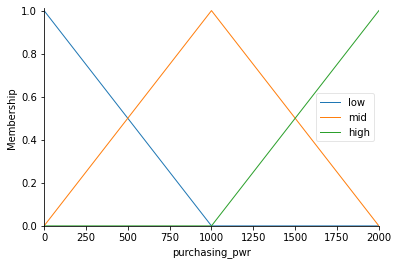

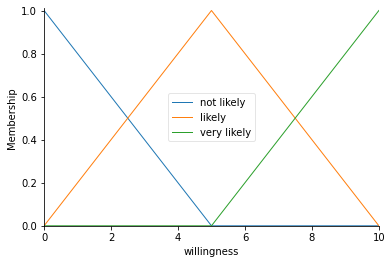

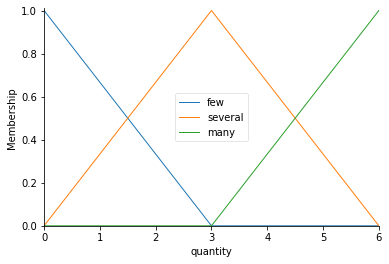

In [22]:
#antecedants
pp = ctrl.Antecedent(np.arange(0, 2001, 500),'purchasing_pwr')
wil = ctrl.Antecedent(np.arange(0, 11, 1), 'willingness')
qty = ctrl.Consequent(np.arange(0, 7, 1), 'quantity')

pp.automf(3, names = ['low', 'mid', 'high'])
wil.automf(3, names = ['not likely', 'likely', 'very likely'])
qty.automf(3, names = ['few', 'several', 'many'])
pp.view(), wil.view(), qty.view();

Text(0.5, 1.0, 'Rule 3 graph')

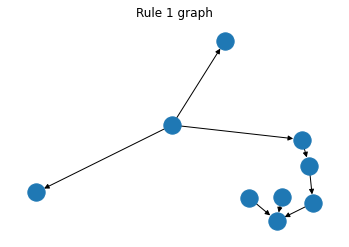

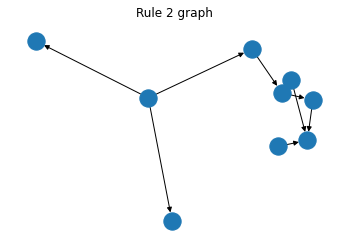

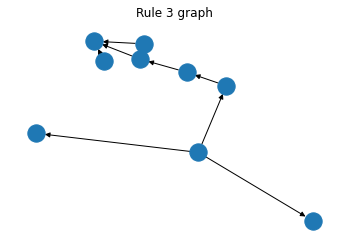

In [23]:
rule1 = ctrl.Rule(pp['low'] or wil['not likely'], qty['few'])
rule2 = ctrl.Rule(pp['mid'], qty['several'])
rule3 = ctrl.Rule(pp['high'] and wil['very likely'], qty['many'])
rule1.view()
plt.title('Rule 1 graph')
rule2.view()
plt.title('Rule 2 graph')
rule3.view()
plt.title('Rule 3 graph')

In [24]:
recommender_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
recommender = ctrl.ControlSystemSimulation(recommender_ctrl)

The recommended qty of customized parts to buy is 3 


c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


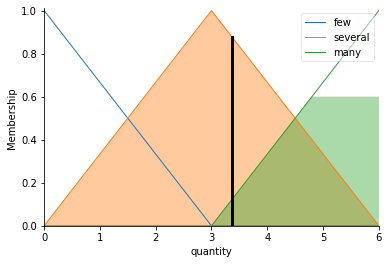

In [25]:
recommender.input['purchasing_pwr'] = 1000
recommender.input['willingness'] = 8
recommender.compute()
s = np.floor(recommender.output['quantity'])
print(f'The recommended qty of customized parts to buy is {s:.0f} ')
qty.view(sim=recommender)

In [26]:
def uniform_sampler(x):
    A = 'car_customize_cost' 
    key1 = get_key(A, 'under 500')
    key2 = get_key(A, '500-1000')
    key3 = get_key(A, 'over 1000')
    if x == int(key1): 
        return np.random.randint(low = 0, high = 500)
    elif x == int(key2): 
        return np.random.randint(low = 500, high = 1000)
    elif x == int(key3):
        return np.random.randint(low = 1000, high = 2000)
    

def willingness_rating(x):
    B = 'car_buy_interest'
    key1 = get_key(B, 'Not likely')
    key2 = get_key(B, 'Likely')
    key3 = get_key(B, 'Very likely')
    if x == int(key1):
        return np.random.randint(low = 0, high = 4)
    elif x == int(key2): 
        return np.random.randint(low = 0, high = 10)
    elif x == int(key3): 
        return np.random.randint(low = 6, high = 10)
    
    
#generate sample data
fuzzy_df = pd.DataFrame()
A = 'car_customize_cost'
B = 'car_buy_interest'
key1 = get_key(A, 'under 500')
key2 = get_key(A, '500-1000')
key3 = get_key(A, 'over 1000')

filter_df = numeric_df['basic'].query(A+'=='+key1+' or '+A+'=='+key2+' or '+A+'=='+key3)
fuzzy_df['purchasing power'] = filter_df[A].apply(uniform_sampler)
fuzzy_df['willingness'] = filter_df[B].apply(willingness_rating)
fuzzy_df = fuzzy_df.reset_index(drop = True)

fuzzy_output = []
for x in range(0, fuzzy_df.shape[0]):
    purchasing_power = fuzzy_df.loc[x, 'purchasing power']
    willingness = fuzzy_df.loc[x, 'willingness']
    recommender.input['purchasing_pwr'] = purchasing_power
    recommender.input['willingness'] = willingness
    recommender.compute()
    qty = np.floor(recommender.output['quantity'])
    fuzzy_output.append(int(qty))

fuzzy_df['quantity recommended'] = fuzzy_output
#display(Latex(fuzzy_df.head(n=10).to_latex()))
fuzzy_df.head(n=10)

,purchasing power,willingness,quantity recommended
0,983,7,3
1,507,8,3
2,282,9,3
3,738,7,3
4,175,9,2
5,1804,9,4
6,577,3,2
7,1090,7,3
8,136,9,2
9,515,7,2


In [27]:
#display(Latex(fuzzy_df.describe().to_latex()))
fuzzy_df.describe()

,purchasing power,willingness,quantity recommended
count,86.000000,86.000000,86.000000
mean,733.813953,6.709302,2.616279
std,481.483504,2.253710,0.556641
min,27.000000,0.000000,2.000000
25%,419.500000,6.000000,2.000000
50%,620.500000,7.000000,3.000000
75%,942.750000,8.000000,3.000000
max,1977.000000,9.000000,4.000000


### Using Apriori Algorithm 

In [28]:
### Recommender using Apriori

full_item = []

for x in fuzzy_df['quantity recommended']:
    list1 = result[result['Quantity'] == x] #car exterior
    list2 = result1[result1['Quantity'] == x] #car interior

    random_select =  np.random.randint(low=1, high=3)
    if random_select == 1: 
        idx = random.choice(list1['Antecedent'].index)
        item1 = list1.loc[idx, 'Antecedent']
        item2 = [list1.loc[idx, 'Consequent']]
        full_item.append(item1 + item2)
    else:
        idx = random.choice(list2['Antecedent'].index)
        item1 = list2.loc[idx, 'Antecedent']
        item2 = [list2.loc[idx, 'Consequent']]
        full_item.append(item1 + item2)

fuzzy_df['recommended item'] = full_item

In [29]:
#display(Latex(fuzzy_df.head(n=25).to_latex()))
fuzzy_df.head(n=25)

,purchasing power,willingness,quantity recommended,recommended item
0,983,7,3,[add body kit and change the exhaust and tune ...
1,507,8,3,"[Grilles, Side mirrors, Headlights]"
2,282,9,3,"[doors, Grilles, Bumpers]"
3,738,7,3,"[Dashboard, Steering wheel, Door handles]"
4,175,9,2,"[Headlights, Bumpers]"
5,1804,9,4,"[Steering wheel, Arm rest, position of gear sh..."
6,577,3,2,"[doors, Bumpers]"
7,1090,7,3,"[Grilles, Side mirrors, Headlights]"
8,136,9,2,"[Sun blocker for front passengers, Centre comp..."
9,515,7,2,"[Wheels, add body kit and change the exhaust a..."


### Revenue Calculation

Total revenue of the company can be calculated by assuming each part can be sold at the purchasing power price and that all customer will buy the recommended item (although not exactly true in reality).

In [30]:
#revenue calculation
fuzzy_df['revenue'] = fuzzy_df['purchasing power'] * fuzzy_df['quantity recommended']
total_revenue = fuzzy_df['revenue'].sum()
print(f'The total revenue that the car company can potentially earn from the recommendations is ${total_revenue}')

The total revenue that the car company can potentially earn from the recommendations is $179946
